In [18]:
####################################################################################################################
#WITH SCALING WITH LOOP
####################################################################################################################

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For data manipulation
import pandas as pd
import numpy as np

# To plot
import matplotlib.pyplot as plt

!pip install iexfinance

# Fetch the Data
from iexfinance.stocks import get_historical_data 
from datetime import datetime

from sklearn.model_selection import GridSearchCV

You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
#L2 like ridge regression (small coefficients preferred)
#L1 like lasso  (coefficients can become zero)
penalty = "l2"  

start = datetime(2017, 1, 1) # starting date: year-month-date
end = datetime(2018, 1, 1) # ending date: year-month-date

#Df = get_historical_data('SPY', start=start, end=end, output_format='pandas')
Df = pd.read_csv("SPY.csv", parse_dates=['Date'])
Df = Df.sort_values(by='Date')
Df.set_index('Date', inplace = True)          
Df= Df.dropna()
Df = Df.rename (columns={'open':'Open', 'high':'High','low':'Low', 'close':'Close'})


In [4]:
Df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,225.039993,225.830002,223.880005,225.240005,216.826019,91366500
2017-01-04,225.619995,226.750000,225.610001,226.580002,218.115921,78744400
2017-01-05,226.270004,226.580002,225.479996,226.399994,217.942657,78379000
2017-01-06,226.529999,227.750000,225.899994,227.210007,218.722412,71559900
2017-01-09,226.910004,227.070007,226.419998,226.460007,218.000443,46265300


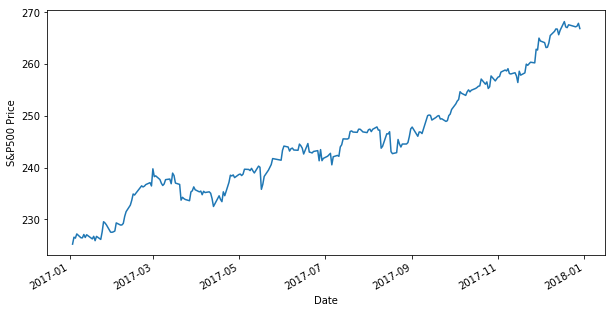

In [5]:
Df.Close.plot(figsize=(10,5))
plt.ylabel("S&P500 Price")
plt.show()


In [6]:
Df.shape

(251, 6)

In [7]:
y = np.where(Df['Close'].shift(-1) > Df['Close'],1,-1)

Df['Open-Close'] = Df.Open - Df.Close
Df['High-Low'] = Df.High - Df.Low
Df['Open-Close_sq'] = Df['Open-Close']*Df['Open-Close']
Df['High-Low_sq'] = Df['High-Low']*Df['High-Low']
Df['Interaction'] = Df['Open-Close']*Df['High-Low']

#see:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
#is another way of doing this


X=Df[['Open-Close','High-Low','Open-Close_sq','High-Low_sq','Interaction']]
X.head()

,Open-Close,High-Low,Open-Close_sq,High-Low_sq,Interaction
Date,,,,,
2017-01-03,-0.200012,1.949997,0.040005,3.802488,-0.390023
2017-01-04,-0.960007,1.139999,0.921613,1.299598,-1.094407
2017-01-05,-0.129990,1.100006,0.016897,1.210013,-0.142990
2017-01-06,-0.680008,1.850006,0.462411,3.422522,-1.258019
2017-01-09,0.449997,0.650009,0.202497,0.422512,0.292502


Text(0,0.5,'High-Low')

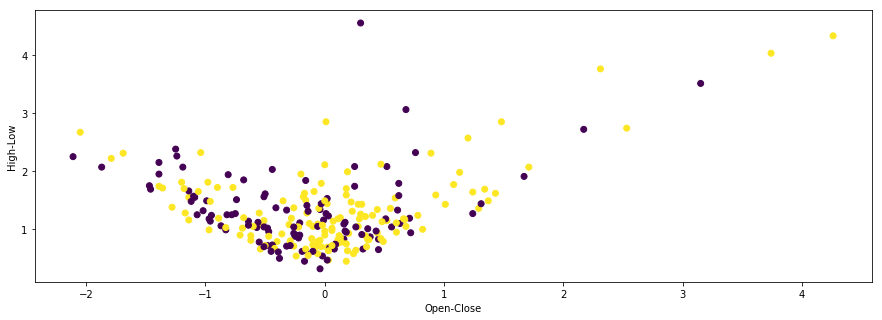

In [8]:
plt.figure(figsize=(15, 5))

plt.scatter(Df['Open-Close'], Df['High-Low'], c=y)
plt.xlabel('Open-Close')
plt.ylabel('High-Low')


In [9]:
split_percentage = 0.8
split = int(split_percentage*len(Df))

# Train data set
X_train = X[:split]
y_train = y[:split] 

# Test data set
X_test = X[split:]
y_test = y[split:]

#there is another way of doing this split with:
#splitting into training and testing
#X_train, X_text, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42) #default=0.25 for test_size

split_percentage = 0.8
split = int(split_percentage*len(X_train))

X_train2 = X_train[:split]
y_train2 = y_train[:split]

# Validation data set
X_val = X_train[split:]
y_val = y_train[split:]


In [10]:
scl = MinMaxScaler()
scl.fit(X_train2)
X_train2 = scl.transform(X_train2)
X_val = scl.transform(X_val)
X_test = scl.transform(X_test)

In [11]:
best_score = 0
for C in [0.001, 0.01, 0.1, 1, 10, 100]: 
    #train a model
    cls = LogisticRegression(penalty=penalty, C=C).fit(X_train, y_train)
    # evaluate the model on the validation set
    score = cls.score(X_val, y_val) #default score is accuracy
    # if we got a better score, store the score and parameters
    if score > best_score:
        best_score = score
        best_parameters = {'C': C}

print("best validation score scaling loop: ", best_score*100)
print("best parameters scaling loop: ", best_parameters)

best validation score scaling loop:  70.0
best parameters scaling loop:  {'C': 0.001}


In [12]:
#set up and run the model with the best parameters
split_percentage = 0.8
split = int(split_percentage*len(Df))
# Train data set
X_train = X[:split]
y_train = y[:split] 
# Test data set
X_test = X[split:]
y_test = y[split:]
scl = MinMaxScaler()
scl.fit(X_train)
X_train = scl.transform(X_train)
X_test = scl.transform(X_test)
cls = LogisticRegression(penalty=penalty, **best_parameters)
cls.fit(X_train, y_train)
test_score = accuracy_score(y_test, cls.predict(X_test))
print("model parameters scaling loop: ", cls.get_params)
print("regression coefficients scaling loop: ", cls.coef_)
print("test score scaling loop: ", test_score*100)

model parameters scaling loop:  <bound method BaseEstimator.get_params of LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>
regression coefficients scaling loop:  [[0.00550372 0.00390261 0.00134729 0.00240537 0.00373395]]
test score scaling loop:  54.90196078431373


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Train Accuracy no scaling no grid: 59.00%
Test Accuracy no scaling no grid: 56.86%


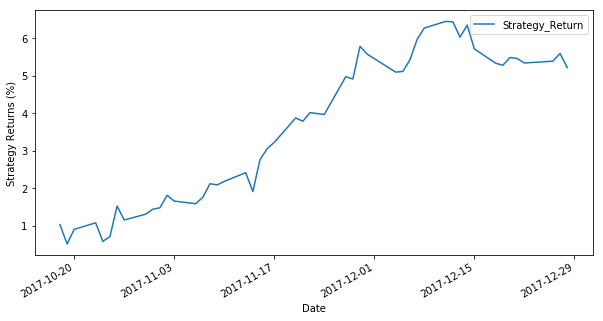

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train data set
X_train = X[:split]
y_train = y[:split] 

#there is another way of doing this split with:
#splitting into training and testing
#X_train, X_text, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42) #default=0.25 for test_size

# Test data set
X_test = X[split:]
y_test = y[split:]

cls = SVC().fit(X_train, y_train)
print(SVC()) #running with default parameters C=1.0, kernel=’rbf’, degree=3, gamma=’auto_deprecated’

accuracy_train = accuracy_score(y_train, cls.predict(X_train))
accuracy_test = accuracy_score(y_test, cls.predict(X_test))

print('\nTrain Accuracy no scaling no grid:{: .2f}%'.format(accuracy_train*100))
print('Test Accuracy no scaling no grid:{: .2f}%'.format(accuracy_test*100))

Df['Predicted_Signal'] = cls.predict(X)
# Calculate log returns
Df['Return'] = np.log(Df.Close.shift(-1) / Df.Close)*100
Df['Strategy_Return'] = Df.Return * Df.Predicted_Signal
PlotDf = pd.DataFrame((Df.Strategy_Return.iloc[split:].cumsum()+1)[0:-1])
PlotDf.plot(figsize=(10,5))
plt.ylabel("Strategy Returns (%)")
plt.show()


In [19]:
param_grid = [{'kernel': ['rbf'], 
               'C': [0.001, 0.01, 0.1, 1, 10, 100], 
                'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['poly'],
              'degree': [0, 1, 2, 3, 4, 5, 6]}]

grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
print("Best parameters no scaling grid: {}".format(best_parameters))
print("Best cross-validation score no scaling grid: {:.2f}".format(grid_search.best_score_*100)) #default is accuracy
print("Test score no scaling grid (grid object): {:.2f}".format(grid_search.score(X_test,y_test)*100)) #default is accuracy

results = pd.DataFrame(grid_search.cv_results_)
#print(results.T)
results.to_csv("results_svc.csv")
#set up and run the model with the best parameters
cls = SVC(**best_parameters)
cls.fit(X_train, y_train)
test_score = accuracy_score(y_test, cls.predict(X_test))
#print("model parameters no scaling grid: ", cls.get_params)
print("test score no scaling grid (model): ", test_score*100)


Best parameters no scaling grid: {'C': 1, 'gamma': 100, 'kernel': 'rbf'}
Best cross-validation score no scaling grid: 57.00
Test score no scaling grid (grid object): 52.94
test score no scaling grid (model):  52.94117647058824


In [20]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


pipe = Pipeline([("scaler", MinMaxScaler()),("svm", SVC())])

param_grid = [{'svm__kernel': ['rbf'], 
               'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 
                'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'svm__kernel': ['linear'],
              'svm__C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'svm__kernel': ['poly'],
               'svm__degree': [0, 1, 2, 3, 4, 5, 6]}]

grid_search = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
print("Best parameters scaling grid: {}".format(best_parameters))
print("Best cross-validation score scaling grid: {:.2f}".format(grid_search.best_score_*100)) #default is accuracy
print("Test score no scaling grid (grid object): {:.2f}".format(grid_search.score(X_test,y_test)*100)) #default is accuracy

results = pd.DataFrame(grid_search.cv_results_)
#print(results.T)
results.to_csv("results_svc_norm.csv")

#set up and run the model with the best parameters
scl = MinMaxScaler()
scl.fit(X_train)
X_train = scl.transform(X_train)
X_test = scl.transform(X_test)
cls = SVC(kernel=best_parameters['svm__kernel'], C=best_parameters['svm__C'], gamma=best_parameters['svm__gamma'])
cls.fit(X_train, y_train)
test_score = accuracy_score(y_test, cls.predict(X_test))
#print("model parameters scaling grid: ", cls.get_params)
print("test score scaling grid (model): ", test_score*100)

Best parameters scaling grid: {'svm__C': 0.001, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
Best cross-validation score scaling grid: 56.00
Test score no scaling grid (grid object): 54.90
test score scaling grid (model):  54.90196078431373


In [22]:
param_grid = [{'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
print("Best parameters no scaling grid: {}".format(best_parameters))
print("Best cross-validation score no scaling grid: {:.2f}".format(grid_search.best_score_*100)) #default is accuracy
print("Test score no scaling grid (grid object): {:.2f}".format(grid_search.score(X_test,y_test)*100)) #default is accuracy

results = pd.DataFrame(grid_search.cv_results_)
#print(results.T)
results.to_csv("results_svc_log.csv")
#set up and run the model with the best parameters
cls = LogisticRegression(**best_parameters)
cls.fit(X_train, y_train)
test_score = accuracy_score(y_test, cls.predict(X_test))
#print("model parameters no scaling grid: ", cls.get_params)
print("test score no scaling grid (model): ", test_score*100)

Best parameters no scaling grid: {'C': 0.001}
Best cross-validation score no scaling grid: 56.00
Test score no scaling grid (grid object): 54.90
test score no scaling grid (model):  54.90196078431373


In [29]:
pipe = Pipeline([("scaler", MinMaxScaler()),("logreg", LogisticRegression())])

param_grid = [{'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100]}]

grid_search = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
print("Best parameters scaling grid: {}".format(best_parameters))
print("Best cross-validation score scaling grid: {:.2f}".format(grid_search.best_score_*100)) #default is accuracy
print("Test score no scaling grid (grid object): {:.2f}".format(grid_search.score(X_test,y_test)*100)) #default is accuracy

results = pd.DataFrame(grid_search.cv_results_)
#print(results.T)
results.to_csv("results_logreg_norm.csv")

#set up and run the model with the best parameters
scl = MinMaxScaler()
scl.fit(X_train)
X_train = scl.transform(X_train)
X_test = scl.transform(X_test)
cls = LogisticRegression(C = best_parameters['logreg__C'])
cls.fit(X_train, y_train)
test_score = accuracy_score(y_test, cls.predict(X_test))
#print("model parameters scaling grid: ", cls.get_params)
print("test score scaling grid (model): ", test_score*100)
print("regression coefficients scaling loop: ", cls.coef_)

Best parameters scaling grid: {'logreg__C': 0.001}
Best cross-validation score scaling grid: 56.00
Test score no scaling grid (grid object): 54.90
test score scaling grid (model):  54.90196078431373
regression coefficients scaling loop:  [[0.00550372 0.00390261 0.00134729 0.00240537 0.00373395]]


In [33]:
pipe = Pipeline([("scaler", MinMaxScaler()),("logreg", LogisticRegression())])

param_grid = [{'logreg__penalty':['l1'],'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100]}]

grid_search = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
print("Best parameters scaling grid: {}".format(best_parameters))
print("Best cross-validation score scaling grid: {:.2f}".format(grid_search.best_score_*100)) #default is accuracy
print("Test score no scaling grid (grid object): {:.2f}".format(grid_search.score(X_test,y_test)*100)) #default is accuracy

results = pd.DataFrame(grid_search.cv_results_)
#print(results.T)
results.to_csv("results_logreg_norm.csv")

#set up and run the model with the best parameters
scl = MinMaxScaler()
scl.fit(X_train)
X_train = scl.transform(X_train)
X_test = scl.transform(X_test)
cls = LogisticRegression(C = best_parameters['logreg__C'], penalty = best_parameters['logreg__penalty'] )
cls.fit(X_train, y_train)
test_score = accuracy_score(y_test, cls.predict(X_test))
#print("model parameters scaling grid: ", cls.get_params)
print("test score scaling grid (model): ", test_score*100)
print("regression coefficients scaling loop: ", cls.coef_)

Best parameters scaling grid: {'logreg__C': 1, 'logreg__penalty': 'l1'}
Best cross-validation score scaling grid: 55.50
Test score no scaling grid (grid object): 56.86
test score scaling grid (model):  56.86274509803921
regression coefficients scaling loop:  [[0.81415863 0.0121923  0.         0.         0.        ]]


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
#seaborn.mpl.rcParams['savefig.dpi'] = 90
'''
https://people.duke.edu/~ccc14/sta-663/ResamplingAndMonteCarloSimulations.html
This subroutine will calculate White's Reality Check for a single trading rule
in accordance with Aronson's Evidence Based Technical Analysis p.237ff

'''

#returns must be detrended by subtracting the average daily return of the benchmark
def bootstrap(ser):
    ser.dropna(inplace=True)
    arr = np.array(ser.values)
    alpha = .05*100 #significance alpha
    reps = 5000 #how many bootstrapings, 50000 limit if you have 8GB RAM

    percentile = 100-alpha
    ave = np.average(arr) #arithmetic mean

    print("average return %f" %ave)

    #ave = ms.gmean(arr) #geometric mean

    centered_arr = arr-ave
    n = len(centered_arr)
    #constructs 50000 alternative return histories and calculates their theoretical averages
    xb = np.random.choice(centered_arr, (n, reps), replace=True)
    mb = xb.mean(axis=0) #arithmetic mean
    #mb = ms.gmean(mb, axis=0) #geometric mean

    #sorts the 50000 averages
    mb.sort()
    #calculates the 95% conficence interval (two tails) threshold for the theoretical averages
    print(np.percentile(mb, [2.5, 97.5])) 
    threshold = np.percentile(mb, [percentile])[0]


    if ave > threshold:
        print("Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)")
    else:
        print("Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)")

    #count will be the items i that are smaller than ave
    count_vals = 0
    for i in mb:
        count_vals += 1
        if i > ave:
            break
        
    #p is based on the count that are larger than ave so 1-count is needed:
    p = 1-count_vals/len(mb)

    print("p_value:")
    print(p)


    '''
    #histogram
    sr = pd.Series(mb)
    desc = sr.describe()
    count = desc[0]
    std = desc[2]
    minim = desc[3]
    maxim = desc[7]
    R = maxim-minim
    n = count
    s = std
    bins = int(round(R*(n**(1/3))/(3.49*std),0))
    fig = sr.hist(bins=bins)
    plt.show()
    '''

    #about the histogram
    #https://stackoverflow.com/questions/33458566/how-to-choose-bins-in-matplotlib-histogram
    #R(n^(1/3))/(3.49σ)
    #R is the range of data (in your case R = 3-(-3)= 6),
    #n is the number of samples,
    #σ is your standard deviation.


In [40]:
bootstrap(Df['Strategy_Return'])

average return 0.062464
[-0.05296832  0.05368168]
Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
p_value:
0.010000000000000009


In [41]:
Df.head()

,Open,High,Low,Close,Adj Close,Volume,Open-Close,High-Low,Open-Close_sq,High-Low_sq,Interaction,Predicted_Signal,Return,Strategy_Return
Date,,,,,,,,,,,,,,
2017-01-03,225.039993,225.830002,223.880005,225.240005,216.826019,91366500,-0.200012,1.949997,0.040005,3.802488,-0.390023,1,0.593157,0.593157
2017-01-04,225.619995,226.750000,225.610001,226.580002,218.115921,78744400,-0.960007,1.139999,0.921613,1.299598,-1.094407,-1,-0.079477,0.079477
2017-01-05,226.270004,226.580002,225.479996,226.399994,217.942657,78379000,-0.129990,1.100006,0.016897,1.210013,-0.142990,1,0.357141,0.357141
2017-01-06,226.529999,227.750000,225.899994,227.210007,218.722412,71559900,-0.680008,1.850006,0.462411,3.422522,-1.258019,1,-0.330637,-0.330637
2017-01-09,226.910004,227.070007,226.419998,226.460007,218.000443,46265300,0.449997,0.650009,0.202497,0.422512,0.292502,1,0.000000,0.000000
